In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report
import warnings
import time

warnings.filterwarnings('ignore')

In [2]:
# random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# Load Data

In [4]:
train_dir = "./train/"
test_dir = "./test/"

emotion_classes = sorted(os.listdir(train_dir))
print(f"\nEmotion classes found: {emotion_classes}")
print(f"Number of classes: {len(emotion_classes)}")


Emotion classes found: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Number of classes: 7


In [5]:
# get no of images per emotion for train and test images
for emotion in emotion_classes:
    train_count = len(os.listdir(os.path.join(train_dir, emotion)))
    test_count = len(os.listdir(os.path.join(test_dir, emotion)))
    print(f"{emotion}: {train_count} train, {test_count} test images")

angry: 3995 train, 958 test images
disgust: 436 train, 111 test images
fear: 4097 train, 1024 test images
happy: 7215 train, 1774 test images
neutral: 4965 train, 1233 test images
sad: 4830 train, 1247 test images
surprise: 3171 train, 831 test images


# Transforming

In [6]:
# train transforms with augmentetion
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # convert to 3 channels for ResNet
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# test transforms without augmentation
test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3 channels for ResNet
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [7]:
# loading dataset
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

print(f"\nTraining samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index mapping: {train_dataset.class_to_idx}")


Training samples: 28709
Test samples: 7178
Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
Class to index mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# Data Loaders

In [8]:
batch_size = 64
num_workers = 4

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 449
Number of test batches: 113


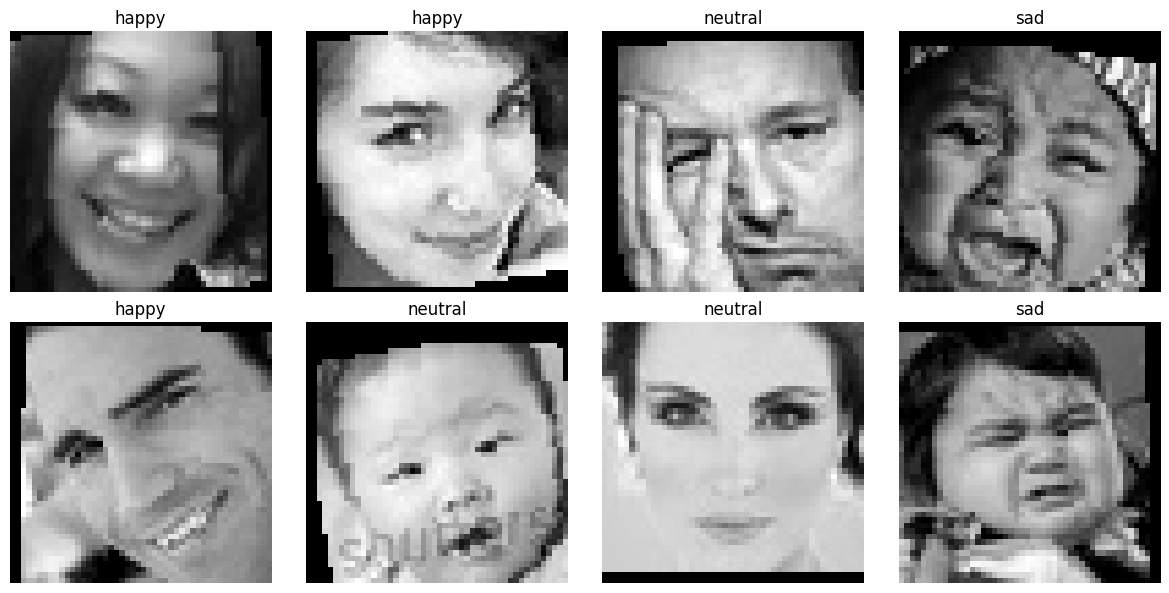

In [9]:
# visualize samples
dataiter = iter(train_loader)
images, labels = next(dataiter)

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for idx, ax in enumerate(axes.flat):
    if idx < len(images):
        # Unnormalize for display
        img = images[idx].numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        
        ax.imshow(img[:, :, 0], cmap='gray')  # Show first channel (they're all the same)
        ax.set_title(train_dataset.classes[labels[idx]])
        ax.axis('off')
plt.tight_layout()
plt.show()

# Class Distribution

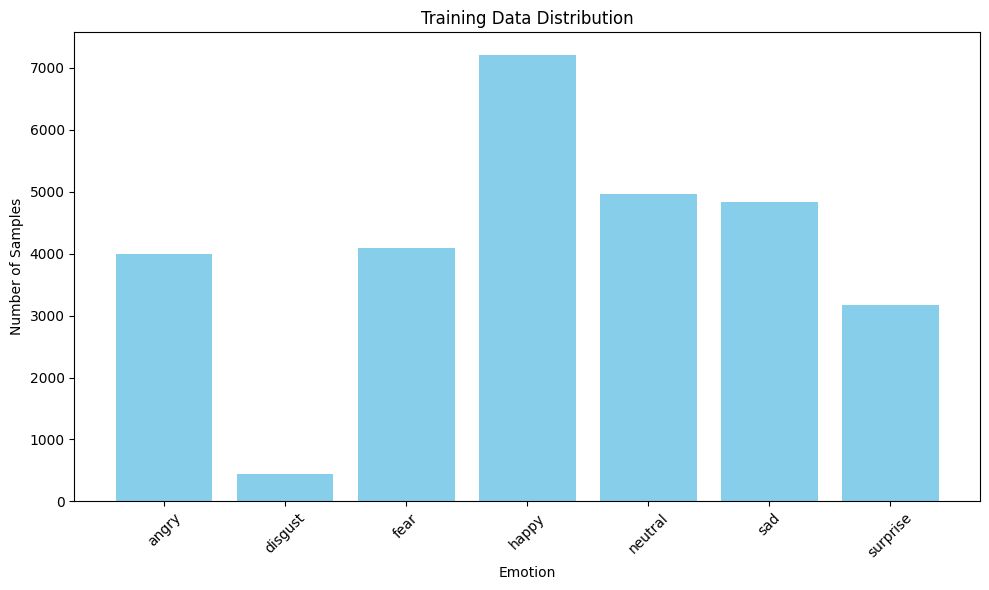

In [10]:
train_labels = [label for _, label in train_dataset]
class_counts = Counter(train_labels)

plt.figure(figsize=(10, 6))
emotion_names = [train_dataset.classes[i] for i in sorted(class_counts.keys())]
counts = [class_counts[i] for i in sorted(class_counts.keys())]

plt.bar(emotion_names, counts, color='skyblue')
plt.xlabel('Emotion')
plt.ylabel('Number of Samples')
plt.title('Training Data Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# calculate class weights
total_samples = len(train_dataset)
class_weights = [total_samples / (len(class_counts) * class_counts[i]) for i in range(len(class_counts))]
print("\nClass weights:", class_weights)


Class weights: [1.0266046844269623, 9.406618610747051, 1.0010460615781582, 0.5684387684387684, 0.8260394187886635, 0.8491274770777877, 1.293372978330405]


# Model Architecture (ResNet18 Model with Transfer Learning)

In [ ]:
class ResNetEmotionClassifier(nn.Module):
    def __init__(self, num_classes=7, pretrained=True):
        super(ResNetEmotionClassifier, self).__init__()
        
        # load pretrained ResNet18
        self.resnet = models.resnet18(pretrained=pretrained)
        
        # get the number of features from the last layer
        num_features = self.resnet.fc.in_features
        
        # replace the final fully connected layer
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

In [13]:
# initialize model
num_classes = len(train_dataset.classes)
model = ResNetEmotionClassifier(num_classes=num_classes, pretrained=True).to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n{'='*50}")
print(f"ResNet18 Model Loaded")
print(f"{'='*50}")
print(f"Total trainable parameters: {count_parameters(model):,}")
print(f"Using pretrained ImageNet weights: Yes")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Kenneth/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:07<00:00, 6.48MB/s]


ResNet18 Model Loaded
Total trainable parameters: 11,309,639
Using pretrained ImageNet weights: Yes


# Training Setup

In [14]:
# loss function with class weights
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# optimizer (using lower learning rate for transfer learning)
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

print(f"\n{'='*50}")
print(f"Training Configuration:")
print(f"{'='*50}")
print(f"Loss function: CrossEntropyLoss with class weights")
print(f"Optimizer: Adam (lr=0.0001, weight_decay=1e-4)")
print(f"Scheduler: ReduceLROnPlateau")
print(f"Note: Lower LR (0.0001) for fine-tuning pretrained model")


Training Configuration:
Loss function: CrossEntropyLoss with class weights
Optimizer: Adam (lr=0.0001, weight_decay=1e-4)
Scheduler: ReduceLROnPlateau
Note: Lower LR (0.0001) for fine-tuning pretrained model


# Train Functions

In [15]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        # forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # backward pass
        loss.backward()
        optimizer.step()
        
        # statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

In [16]:
def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total
    
    return epoch_loss, epoch_acc

# Training Loop

In [17]:
num_epochs = 50
best_acc = 0.0
train_losses, train_accs = [], []
val_losses, val_accs = [], []

print(f"\n{'='*50}")
print(f"Starting Training with ResNet18...")
print(f"{'='*50}\n")

for epoch in range(num_epochs):
    start_time = time.time()
    
    # train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # validate
    val_loss, val_acc = validate(model, test_loader, criterion, device)
    
    # update scheduler
    scheduler.step(val_loss)
    
    # save history
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # save best model
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'class_to_idx': train_dataset.class_to_idx
        }, 'best_resnet18_emotion_model.pth')
        print(f'✓ New best ResNet18 model saved!')
    
    # print progress
    epoch_time = time.time() - start_time
    print(f'Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s) | '
          f'Train Loss: {train_loss:.4f} Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} Acc: {val_acc:.2f}%')

print(f"\n{'='*50}")
print(f"Training Complete!")
print(f"{'='*50}")
print(f"Best validation accuracy: {best_acc:.2f}%")


Starting Training with ResNet18...

✓ New best ResNet18 model saved!
Epoch [1/50] (413.3s) | Train Loss: 1.7826 Acc: 28.81% | Val Loss: 1.4694 Acc: 44.41%
✓ New best ResNet18 model saved!
Epoch [2/50] (382.2s) | Train Loss: 1.4903 Acc: 42.90% | Val Loss: 1.3393 Acc: 49.18%
✓ New best ResNet18 model saved!
Epoch [3/50] (447.2s) | Train Loss: 1.3840 Acc: 47.62% | Val Loss: 1.2801 Acc: 51.49%
✓ New best ResNet18 model saved!
Epoch [4/50] (442.6s) | Train Loss: 1.2981 Acc: 50.71% | Val Loss: 1.2482 Acc: 52.87%
✓ New best ResNet18 model saved!
Epoch [5/50] (446.7s) | Train Loss: 1.2504 Acc: 52.19% | Val Loss: 1.1752 Acc: 55.43%
Epoch [6/50] (454.8s) | Train Loss: 1.2053 Acc: 54.10% | Val Loss: 1.2013 Acc: 55.22%
✓ New best ResNet18 model saved!
Epoch [7/50] (449.7s) | Train Loss: 1.1703 Acc: 54.94% | Val Loss: 1.1325 Acc: 57.33%
✓ New best ResNet18 model saved!
Epoch [8/50] (446.3s) | Train Loss: 1.1264 Acc: 56.29% | Val Loss: 1.1560 Acc: 57.48%
✓ New best ResNet18 model saved!
Epoch [9/50

# Plot Training History

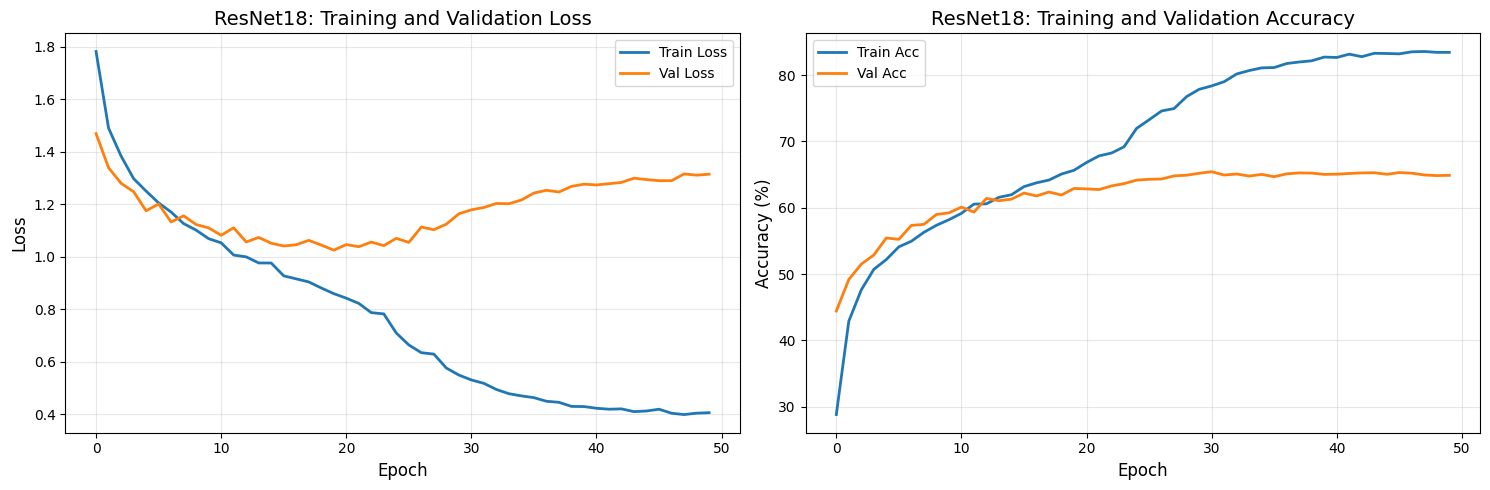

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('ResNet18: Training and Validation Loss', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# accuracy plot
ax2.plot(train_accs, label='Train Acc', linewidth=2)
ax2.plot(val_accs, label='Val Acc', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('ResNet18: Training and Validation Accuracy', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Load best model and evaluate

In [19]:
checkpoint = torch.load('best_resnet18_emotion_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best ResNet18 model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")


Loaded best ResNet18 model from epoch 31
Best validation accuracy: 65.42%


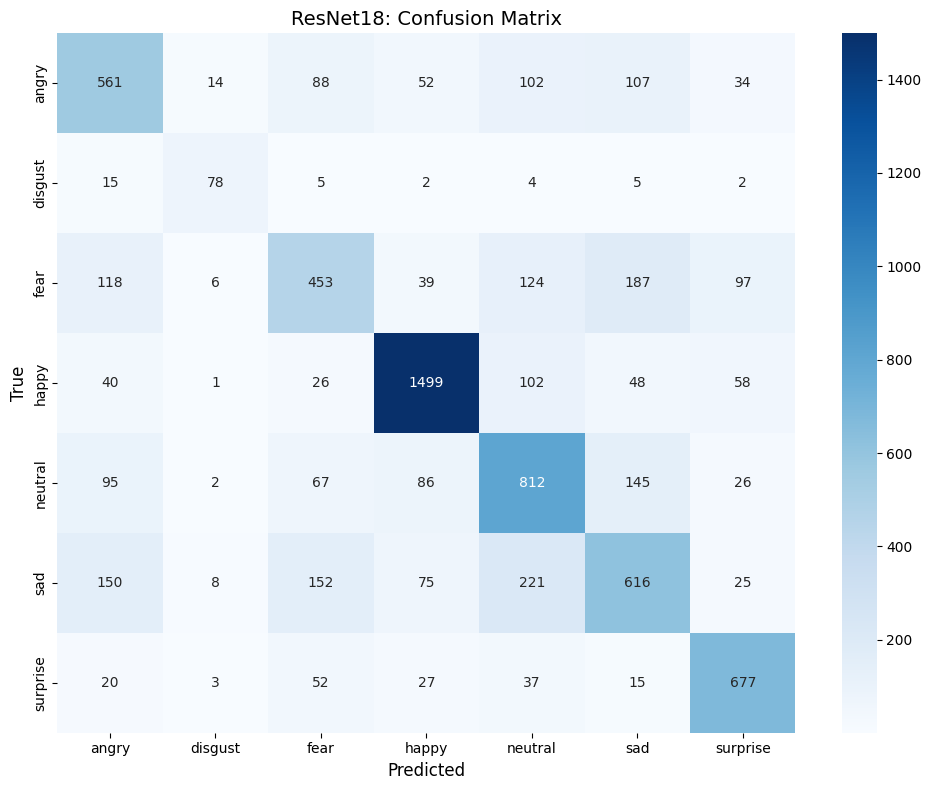

In [21]:
# confusion matrix
def get_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    return np.array(all_preds), np.array(all_labels)

# get predictions
preds, labels = get_predictions(model, test_loader, device)

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('ResNet18: Confusion Matrix', fontsize=14)
plt.tight_layout()
plt.show()

In [22]:
# classification report
print(f"\n{'='*50}")
print(f"ResNet18 Classification Report:")
print(f"{'='*50}\n")
print(classification_report(labels, preds, target_names=train_dataset.classes))


ResNet18 Classification Report:

              precision    recall  f1-score   support

       angry       0.56      0.59      0.57       958
     disgust       0.70      0.70      0.70       111
        fear       0.54      0.44      0.49      1024
       happy       0.84      0.84      0.84      1774
     neutral       0.58      0.66      0.62      1233
         sad       0.55      0.49      0.52      1247
    surprise       0.74      0.81      0.77       831

    accuracy                           0.65      7178
   macro avg       0.64      0.65      0.64      7178
weighted avg       0.65      0.65      0.65      7178



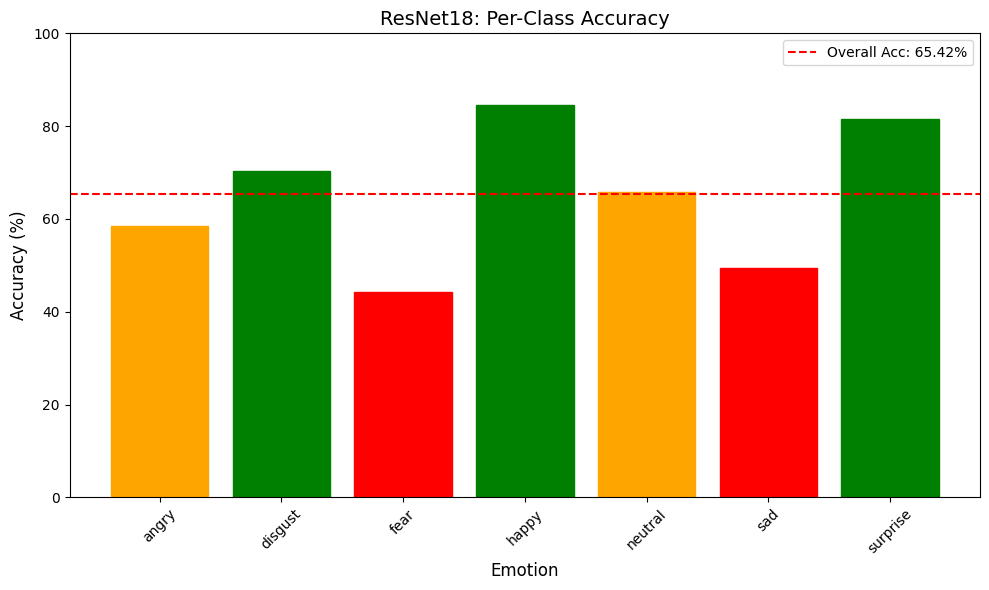

In [ ]:
# per class accuracy
per_class_correct = np.zeros(num_classes)
per_class_total = np.zeros(num_classes)

for i in range(len(labels)):
    true_label = labels[i]
    pred_label = preds[i]
    
    per_class_total[true_label] += 1
    if true_label == pred_label:
        per_class_correct[true_label] += 1

per_class_acc = 100 * per_class_correct / per_class_total

plt.figure(figsize=(10, 6))
bars = plt.bar(train_dataset.classes, per_class_acc)

# color bars based on accuracy
for i, bar in enumerate(bars):
    if per_class_acc[i] < 50:
        bar.set_color('red')
    elif per_class_acc[i] < 70:
        bar.set_color('orange')
    else:
        bar.set_color('green')

plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.title('ResNet18: Per-Class Accuracy', fontsize=14)
plt.xticks(rotation=45)
plt.ylim([0, 100])
plt.axhline(y=best_acc, color='r', linestyle='--', label=f'Overall Acc: {best_acc:.2f}%')
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
print(f"\n{'='*50}")
print(f"ResNet18 Per-Class Accuracy:")
print(f"{'='*50}")
for i, emotion in enumerate(train_dataset.classes):
    print(f"{emotion:12s}: {per_class_acc[i]:.2f}%")


ResNet18 Per-Class Accuracy:
angry       : 58.56%
disgust     : 70.27%
fear        : 44.24%
happy       : 84.50%
neutral     : 65.86%
sad         : 49.40%
surprise    : 81.47%


# Visualize predictions

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=16):
    model.eval()
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    
    for idx, ax in enumerate(axes.flat):
        if idx < num_samples:
            # get random sample
            sample_idx = np.random.randint(len(dataset))
            img, true_label = dataset[sample_idx]
            
            # predict
            with torch.no_grad():
                img_input = img.unsqueeze(0).to(device)
                output = model(img_input)
                probabilities = torch.softmax(output, dim=1)
                pred_label = output.argmax(1).item()
                confidence = probabilities[0][pred_label].item()
            
            # display - unnormalize
            img_display = img.numpy().transpose((1, 2, 0))
            img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            img_display = np.clip(img_display, 0, 1)
            
            ax.imshow(img_display[:, :, 0], cmap='gray')
            
            true_name = dataset.classes[true_label]
            pred_name = dataset.classes[pred_label]
            
            color = 'green' if true_label == pred_label else 'red'
            ax.set_title(f'True: {true_name}\nPred: {pred_name} ({confidence:.2f})',
                        color=color, fontsize=9)
            ax.axis('off')
    
    plt.tight_layout()
    plt.suptitle('ResNet18 Predictions (Green=Correct, Red=Incorrect)', 
                 fontsize=14, y=1.002)
    plt.show()

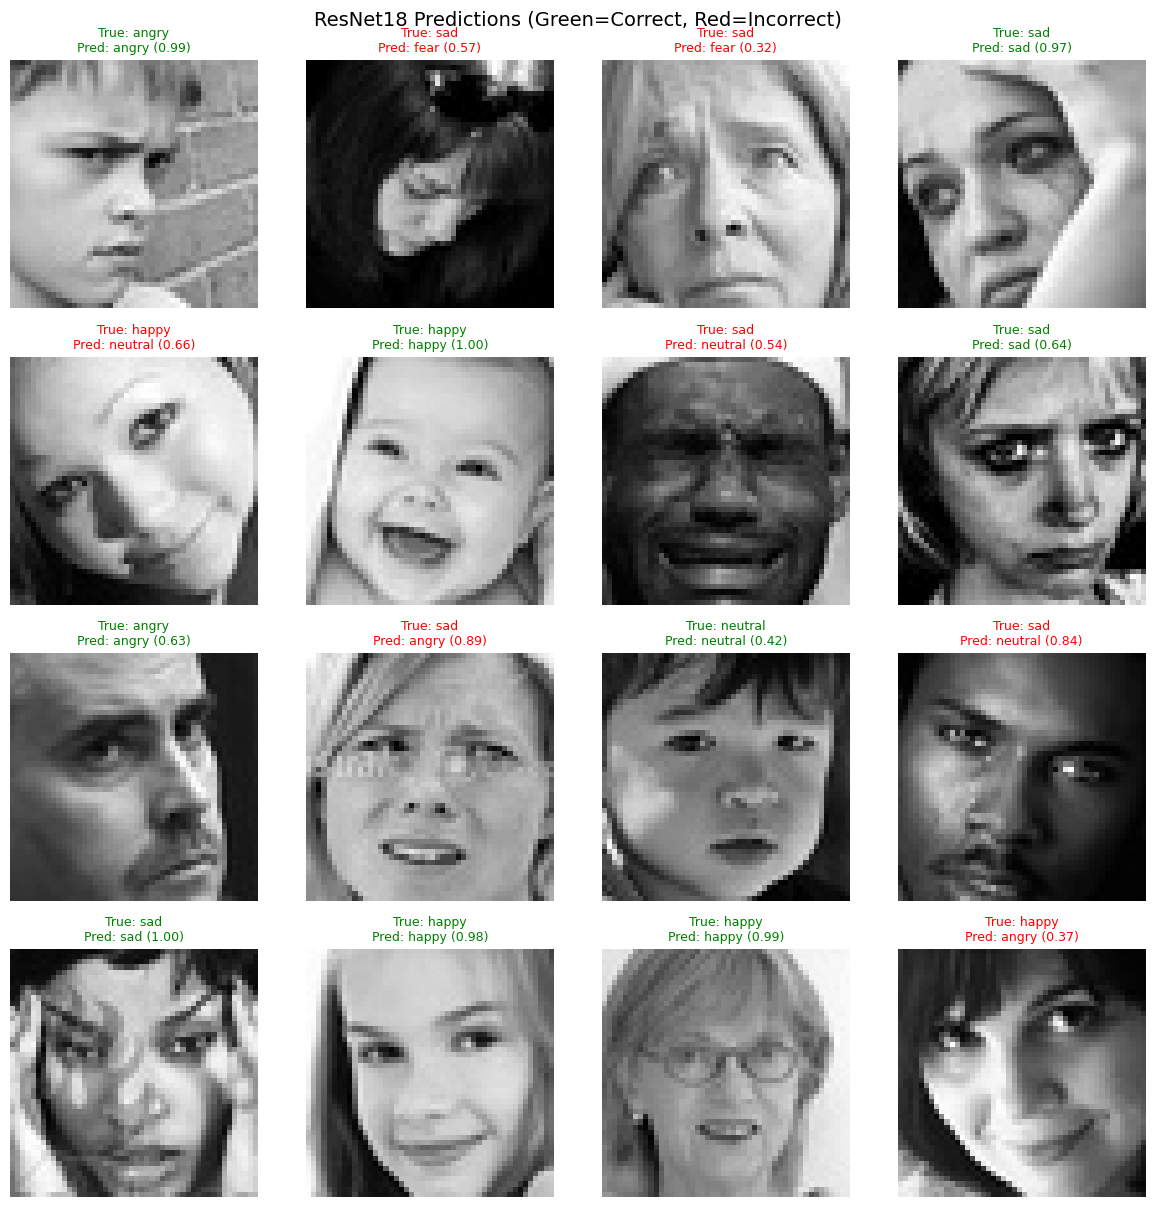

In [26]:
visualize_predictions(model, test_dataset, device, num_samples=16)

In [28]:
print(f"\n{'='*50}")
print(f"ResNet18 Training Summary:")
print(f"{'='*50}")
print(f"Total epochs: {num_epochs}")
print(f"Best validation accuracy: {best_acc:.2f}%")
print(f"Model saved as: best_resnet18_emotion_model.pth")
print(f"{'='*50}\n")


ResNet18 Training Summary:
Total epochs: 50
Best validation accuracy: 65.42%
Model saved as: best_resnet18_emotion_model.pth

